In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[y_train.squeeze() == 1]
X_train = (X_train / 127.5) - 1.0

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

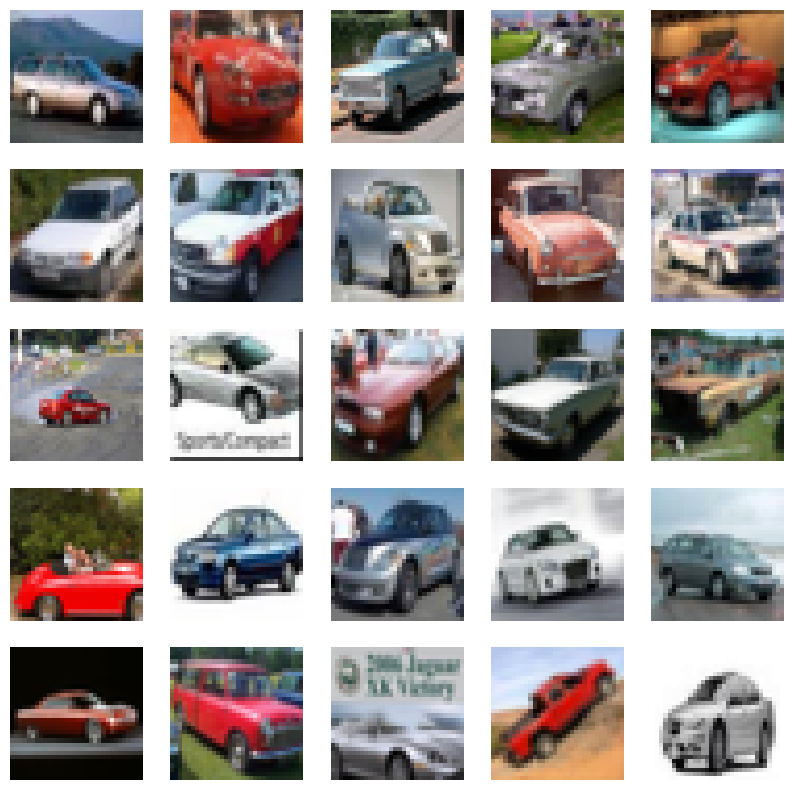

In [ ]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

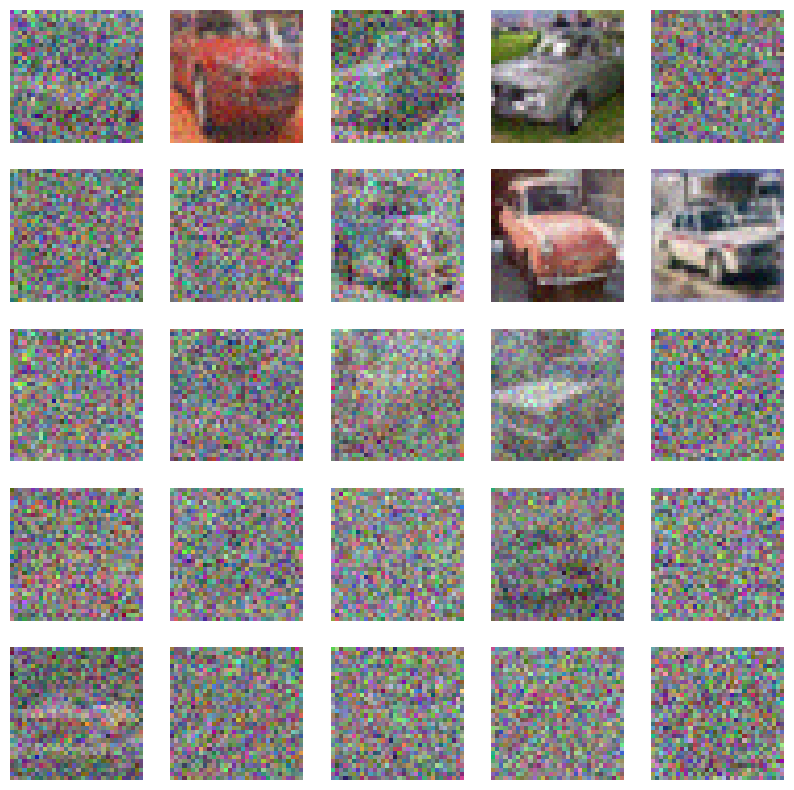

In [ ]:
t = generate_ts(25)             # random for training data
a, b = forward_noise(X_train[:25], t)
show_examples(b)

In [ ]:
def plot_forward_noise(x, t):
  plt.figure(figsize=(20, 2))
  for i in range(8):
    img_t, _ = forward_noise(x, i)
    plt.subplot(1, 8, i+1)
    plt.imshow(cvtImg(img_t[0]))
    plt.axis('off')
    plt.title(f'{i+1}')
  plt.show()

# plot_forward_noise(X_train[20:21], t[20:21])

In [ ]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

In [ ]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
model.summary()

# # Get a list of layers and their types
# layer_types = [layer.__class__.__name__ for layer in model.layers]

# # Count the occurrences of each layer type
# layer_counts = {layer_type: layer_types.count(layer_type) for layer_type in set(layer_types)}

# # Print the count of each layer type
# for layer_type, count in layer_counts.items():
#     print(f"Layer: {layer_type}, Count: {count}")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 192)                  384       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192)                  0         ['layer_normalization[0][0

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)
print("Model Compiled")

Model Compiled


  0%|          | 0/16 [00:00<?, ?it/s]

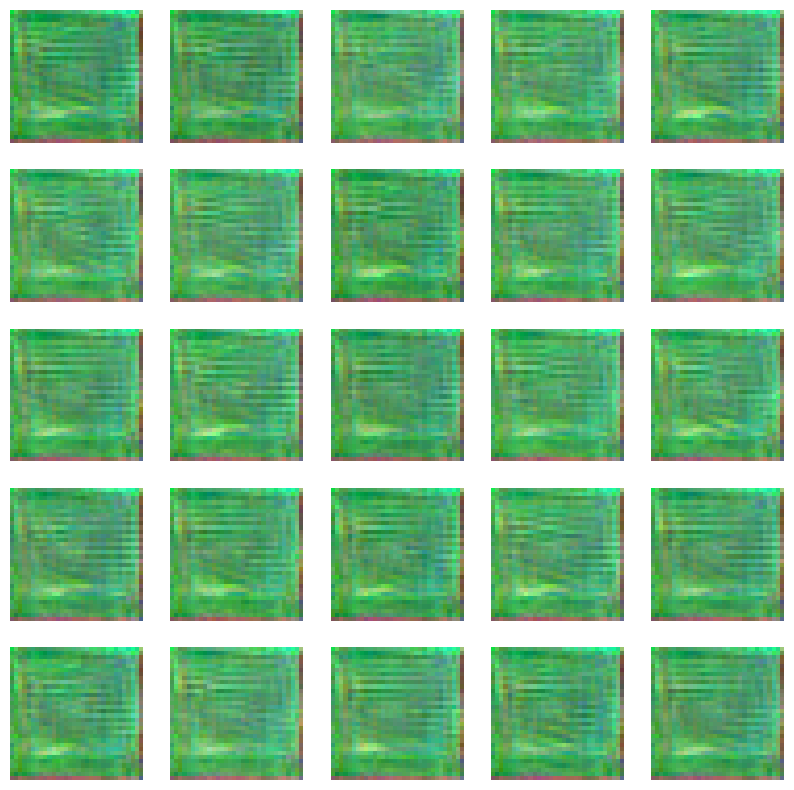

In [ ]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

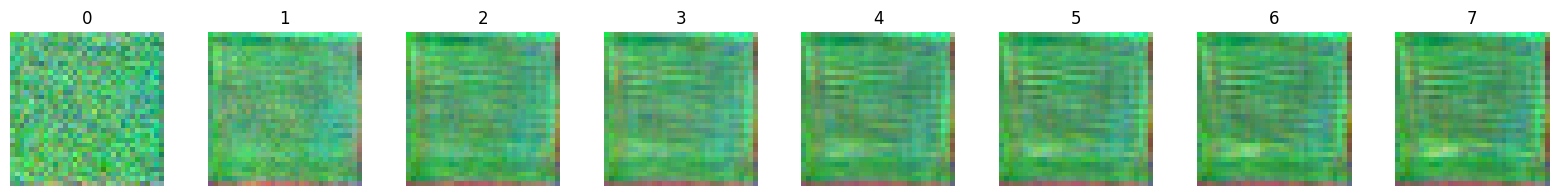

In [ ]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [ ]:
from keras.models import load_model, save_model

def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    # model.save('/content/drive/MyDrive/Trained Models/diff_model.h5')
    return loss

In [ ]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

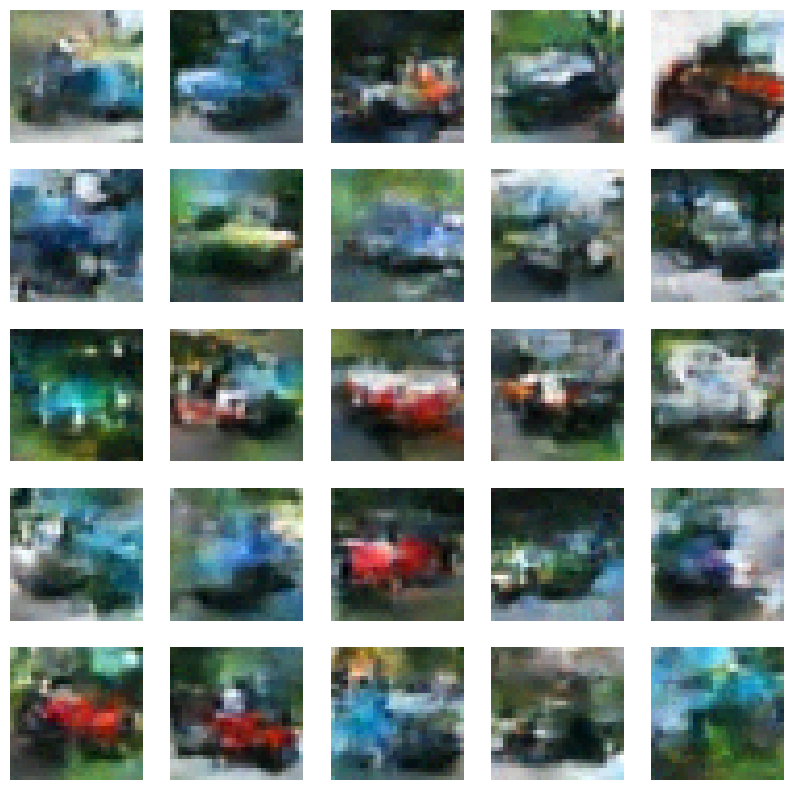

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

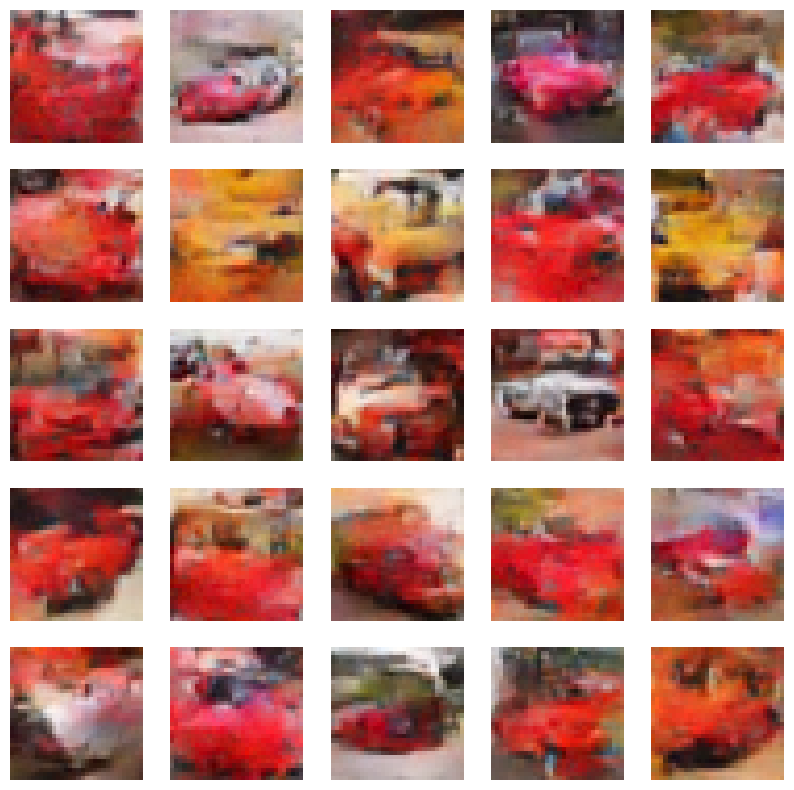

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

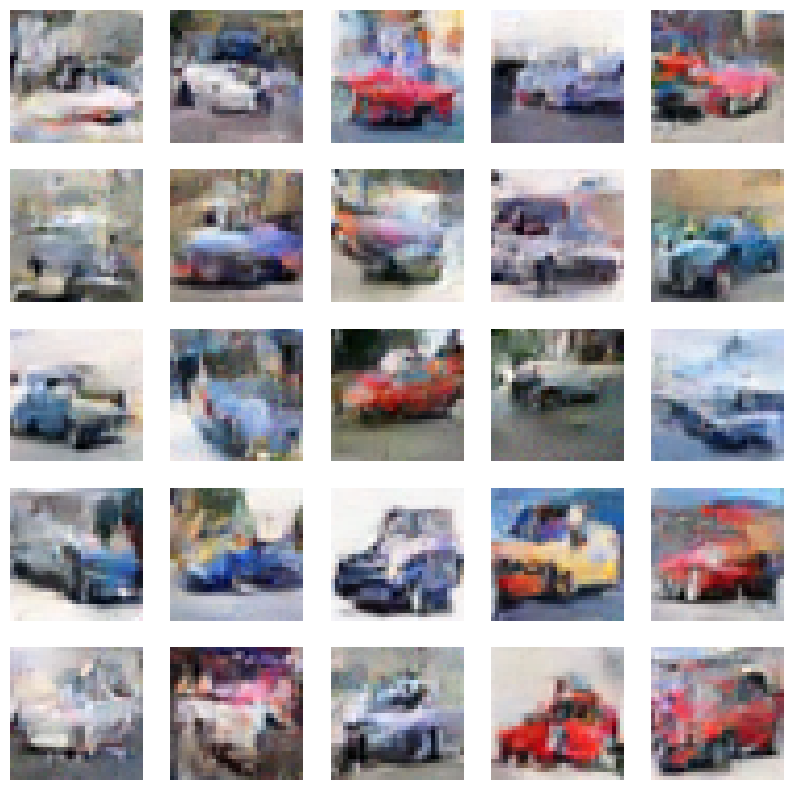

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

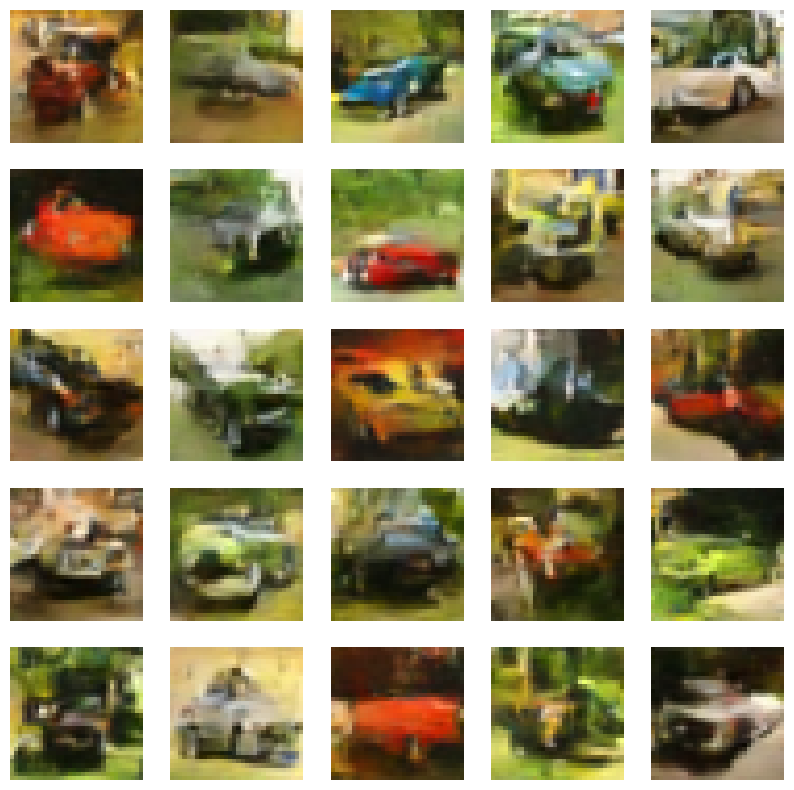

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

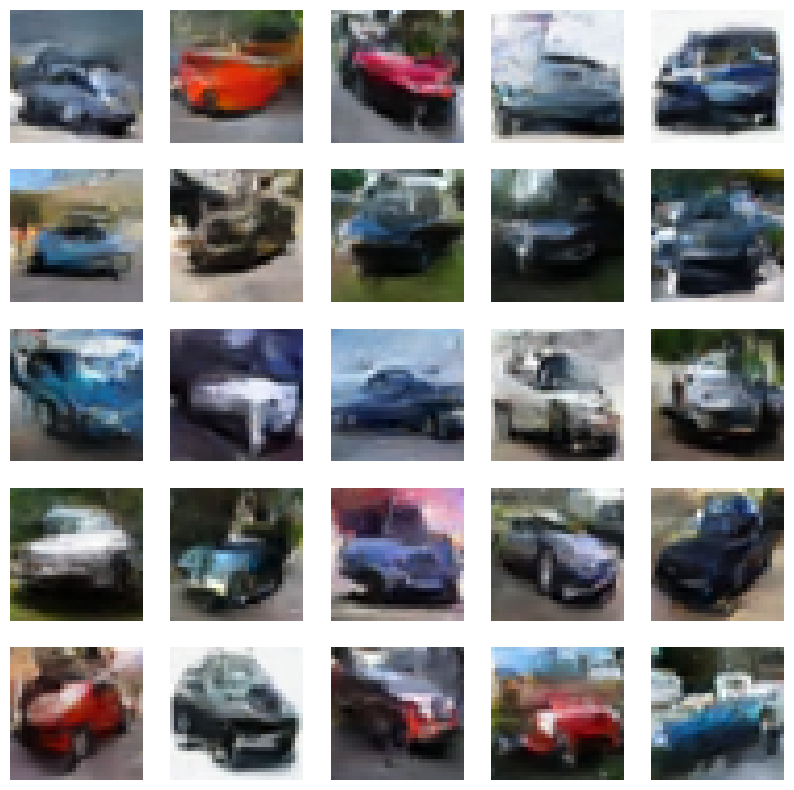

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

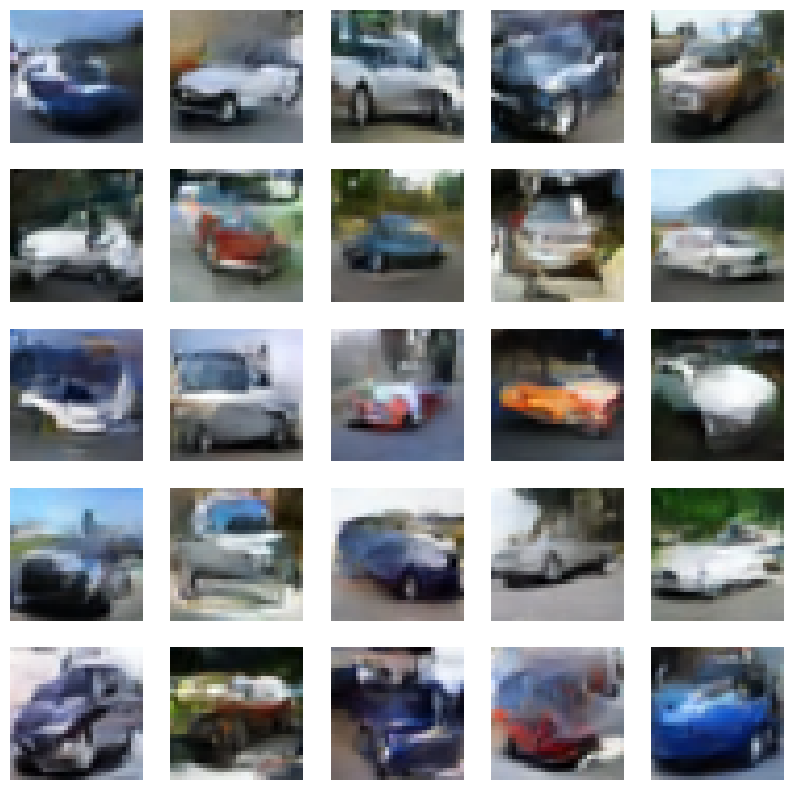

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

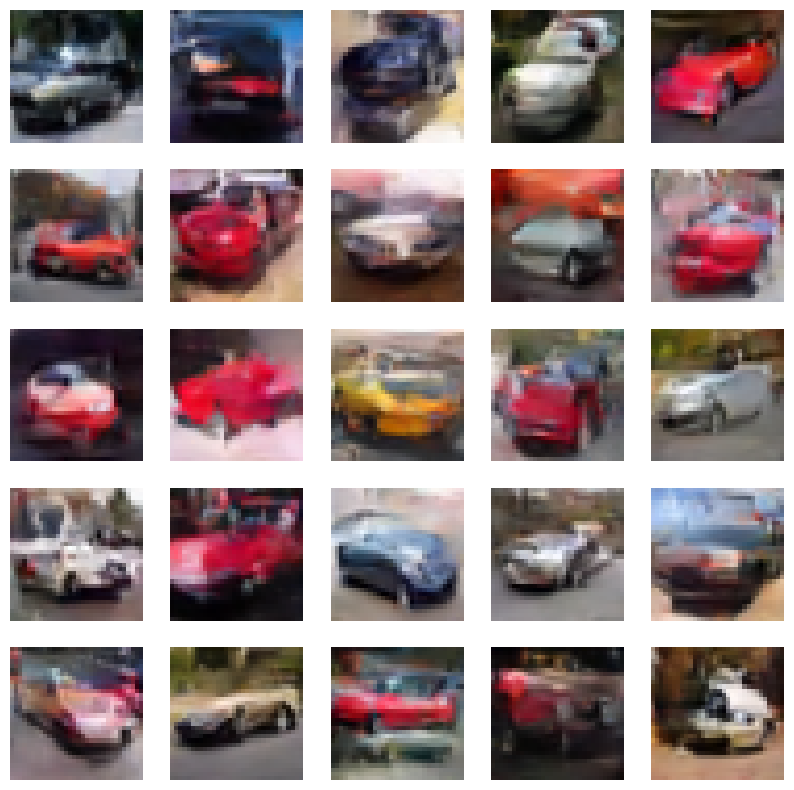

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

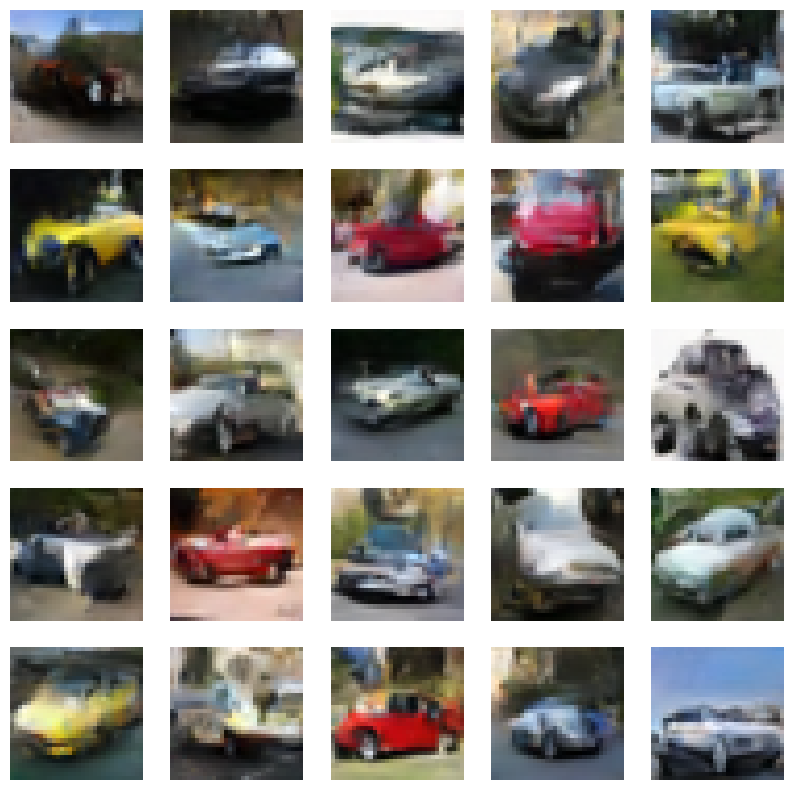

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

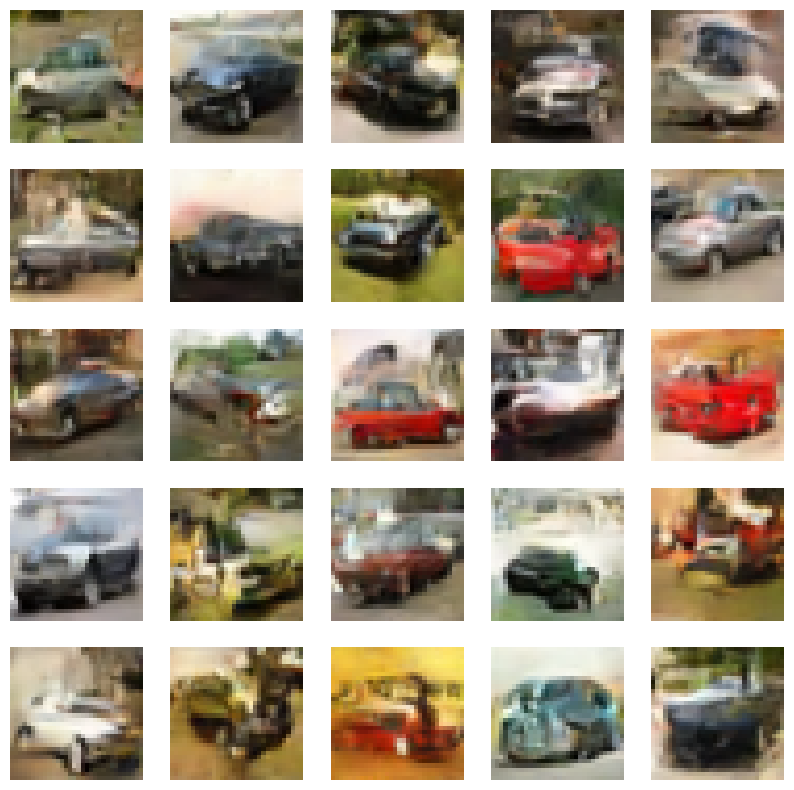

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

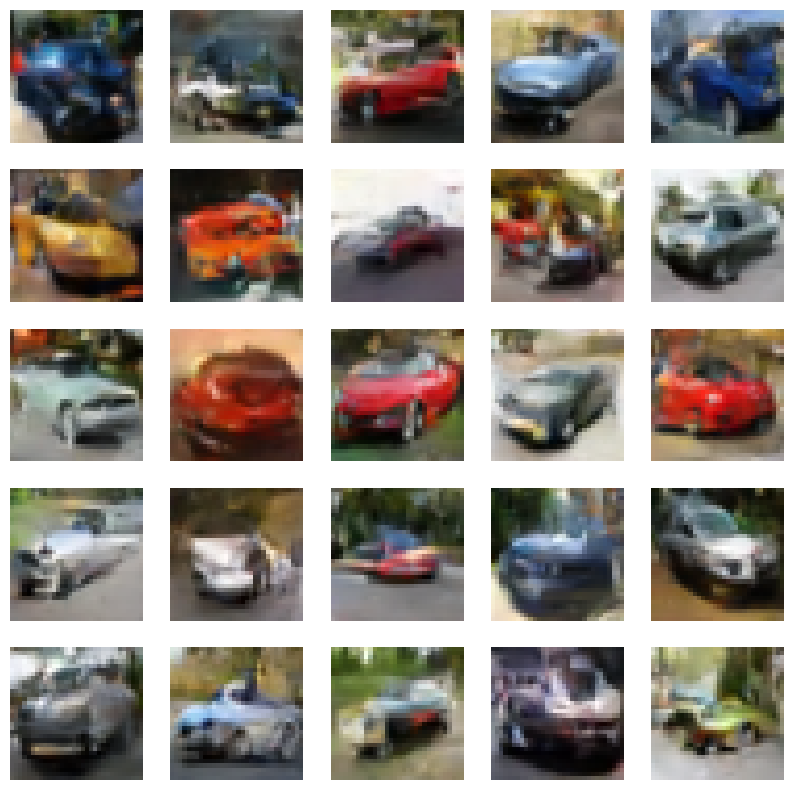

In [ ]:
for _ in range(10):
    train()
    model.optimizer.learning_rate = max(0.0001, model.optimizer.learning_rate * 0.9)
    predict()
    plt.show()

In [ ]:
from skimage.draw import line

def generate_mask(width, height):
    image = np.zeros((height, width), dtype=np.uint8)

    x_start = np.random.randint(0, width)
    y_start = np.random.randint(0, height)
    x_end = np.random.randint(0, width)
    y_end = np.random.randint(0, height)

    rows, cols = line(y_start, x_start, y_end, x_end)
    image[rows, cols] = 255

    return image

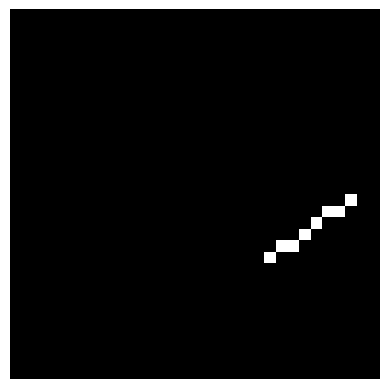

In [ ]:
image_mask = generate_mask(IMG_SIZE, IMG_SIZE)

plt.imshow(cvtImg(image_mask), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def mask_image(x, mask):
  s = x.min()
  for w in range(IMG_SIZE):
    for h in range(IMG_SIZE):
      if mask[w][h] != 0:
        x[w][h] = [1, 1, 1]
  return cvtImg(x)

In [ ]:
model.save("/content/drive/MyDrive/diffusion-model/v1.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/diffusion-model/v1.h5")

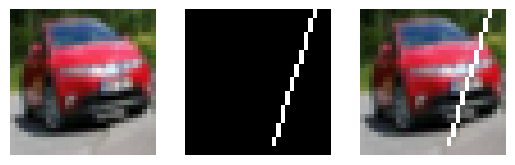

In [ ]:
sample_image = X_train[np.random.randint(len(X_train))].copy()
plt.subplot(1, 3, 1)
plt.imshow(cvtImg(sample_image))
plt.axis("off")

sample_mask = generate_mask(IMG_SIZE, IMG_SIZE)
plt.subplot(1, 3, 2)
plt.imshow(cvtImg(sample_mask), cmap='gray')
plt.axis("off")

sample_masked = mask_image(sample_image.copy(), mask=sample_mask)
plt.subplot(1, 3, 3)
plt.imshow(cvtImg(sample_masked))
plt.axis("off")

plt.show()

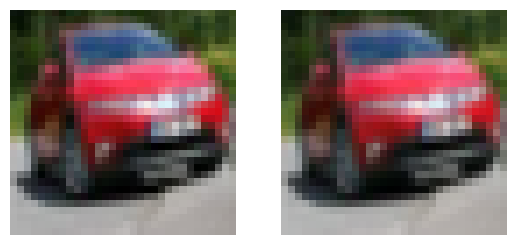

In [ ]:
modified_sample_image = np.expand_dims(sample_image, axis=0)
prediction = model.predict([modified_sample_image, np.full((1),  1)], verbose=0)

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(cvtImg(sample_image))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(cvtImg(np.squeeze(prediction, axis=0)))

In [ ]:
accuracy = np.mean(np.abs(modified_sample_image - prediction) < 0.05)
print(f"Accuracy: {accuracy}")

Accuracy: 0.828125


In [ ]:
[sample_mask == 255]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])